In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision import transforms


def get_transforms(std=0.5, mean=0.5):
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((mean,), (std,))
    ])
    
def cut_data(data, first_proportion=0.8):
    first_size = int(len(data) * first_proportion)
    second_size = len(data) - first_size
    first_data, second_data = torch.utils.data.random_split(data, [first_size, second_size])
    return first_data, second_data

def get_data_MNIST(std=0.5, mean=0.5, train_size=0.8):
    train_data = datasets.MNIST(root='data', train=True, transform=get_transforms(std, mean), download=True)
    test_data = datasets.MNIST(root='data', train=False, transform=get_transforms(std, mean), download=True)
    train_data, val_data = cut_data(train_data, train_size)
    return train_data, val_data, test_data

def get_data_CIFAR10(std=0.5, mean=0.5, train_size=0.8):
    train_data = datasets.CIFAR10(root='data', train=True, transform=get_transforms(std, mean), download=True)
    test_data = datasets.CIFAR10(root='data', train=False, transform=get_transforms(std, mean), download=True)
    train_data, val_data = cut_data(train_data, train_size)
    return train_data, val_data, test_data

def inspect(data):
    print(f"Data type: {type(data)}")
    print(f"Data length: {len(data)}")
    print(f"Data shape: {data[0][0].shape}")
    
def check_data(train_data, val_data, test_data):
    inspect(train_data)
    inspect(val_data)
    inspect(test_data)
    # Total de datos
    print(f"Total data: {len(train_data) + len(val_data) + len(test_data)}\n")

In [3]:
train_mnist, val_mnist, test_mnist = get_data_MNIST()
check_data(train_mnist, val_mnist, test_mnist)
train_cifar10, val_cifar10, test_cifar10 = get_data_CIFAR10()
check_data(train_cifar10, val_cifar10, test_cifar10)

Data type: <class 'torch.utils.data.dataset.Subset'>
Data length: 48000
Data shape: torch.Size([1, 28, 28])
Data type: <class 'torch.utils.data.dataset.Subset'>
Data length: 12000
Data shape: torch.Size([1, 28, 28])
Data type: <class 'torchvision.datasets.mnist.MNIST'>
Data length: 10000
Data shape: torch.Size([1, 28, 28])
Total data: 70000

Files already downloaded and verified
Files already downloaded and verified
Data type: <class 'torch.utils.data.dataset.Subset'>
Data length: 40000
Data shape: torch.Size([3, 32, 32])
Data type: <class 'torch.utils.data.dataset.Subset'>
Data length: 10000
Data shape: torch.Size([3, 32, 32])
Data type: <class 'torchvision.datasets.cifar.CIFAR10'>
Data length: 10000
Data shape: torch.Size([3, 32, 32])
Total data: 60000



In [4]:
# Plotear una imagen de ejemplo
def plot_image(data, index):
    image, label = data[index]
    fig = plt.figure(figsize=(5, 5))
    # Check rgb or grayscale
    if image.shape[0] == 1:
        image = image[0]
        plt.imshow(image, cmap='gray')
    else:
        image = image.permute(1, 2, 0)
        plt.imshow(image)
    plt.title(f"Label: {label}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


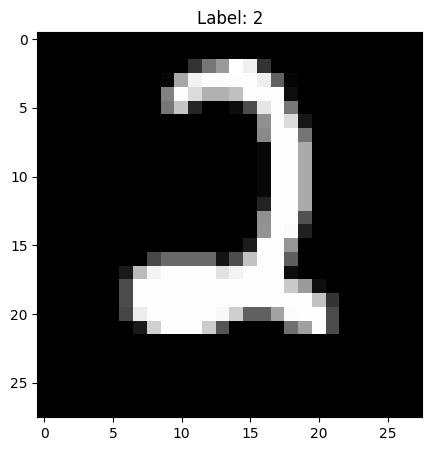

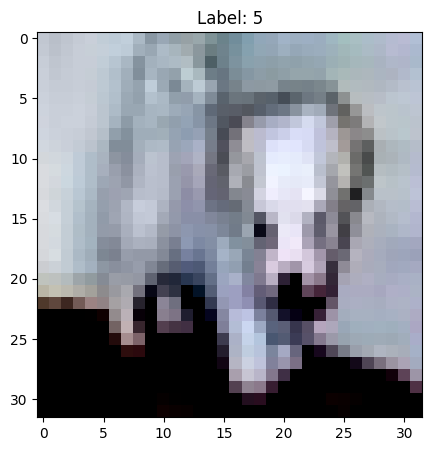

In [5]:
plot_image(train_mnist, 10)
plot_image(train_cifar10, 10) 

In [15]:
# Creamos una capa de convolución

class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1):
        super(ConvLayer, self).__init__()
        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        return self.relu(self.conv(x))
    
# Max Pooling + Batch Normalization + Dropout (opcional)
class MaxPoolBN(torch.nn.Module): 
    def __init__(self, in_channels, kernel_size = 2, stride=2, padding=0, dropout=0.1):
        super(MaxPoolBN, self).__init__()
        self.max_pool = torch.nn.MaxPool2d(kernel_size, stride, padding)
        self.bn = torch.nn.BatchNorm2d(in_channels)
        self.dropout = torch.nn.Dropout(dropout)
        
    def forward(self, x):
        return self.dropout(self.bn(self.max_pool(x)))
    
# Capa densa + dropout (opcional)
class Dense(torch.nn.Module):
    def __init__(self, in_features, out_features, dropout=0.1):
        super(Dense, self).__init__()
        self.linear = torch.nn.Linear(in_features, out_features)
        self.dropout = torch.nn.Dropout(dropout)
        
    def forward(self, x):
        return self.dropout(self.linear(x))
    
# structure = [L1, k1, ..., Ln, kn], con L la cantidad de capas y k el kernel size
class ConvNet(torch.nn.Module):
    def __init__(self,in_channels, structure, size=28, classes=10):
        super(ConvNet, self).__init__()
        self.size = size
        self.structure = structure
        self.L = [structure[i] for i in range(len(structure)) if i % 2 == 0]
        self.k = [structure[i] for i in range(len(structure)) if i % 2 == 1]
        self.layers = torch.nn.ModuleList()
        for i in range(len(self.L)):
            if i == 0:
                self.layers.append(ConvLayer(in_channels, self.L[i], self.k[i]))
            else:
                self.layers.append(ConvLayer(self.L[i-1], self.L[i], self.k[i]))
            
            # Max pooling en cantidad par de capas 
            if i % 2 == 1:
                self.layers.append(MaxPoolBN(self.L[i], 2))
                self.size = self.size // 2
                
        # Caso impares
        if len(self.L) % 2 == 1:
            self.layers.append(MaxPoolBN(self.L[-1], 2))
            self.size = self.size // 2
            
        # Cabeza clasificadora
        self.layers.append(torch.nn.Flatten())
        self.layers.append(Dense(self.L[-1] * self.size * self.size, 128))
        self.layers.append(Dense(128, classes))
                
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
# Profundidad de CIFAR10 (32/2^4 = 2 -> 4x2 capas convolucionales maximo) depth in [2,8]
# E:32 --c1--> 32 --c2--> 32 --MP-->
# 16 --c3--> 16 --c4--> 16 --MP-->
# 8 --c5--> 8 --c6--> 8 --MP-->
# 4 --c7--> 4 --c8--> 4 --MP--> 2 

In [7]:
# Probar con un batch de entrada 1 x 1 x 28 x 28
# Cargamos el dataset de CIFAR10
train_data, val_data, test_data = get_data_CIFAR10()

Files already downloaded and verified
Files already downloaded and verified


In [16]:
# Creamos el modelo
L = [64, 64, 128, 128, 128, 128, 64, 64]
k = [ 3,  3,   3,   3,   3,   3,  3,  3]
structure = [item for sublist in [[L[i], k[i]] for i in range(len(L)) ] for item in sublist]

# Obtener un ejemplo de entrada
x, y = train_data[0]
x = x.unsqueeze(0)
print(f"Input shape: {x.shape}")

# Creamos el modelo
model = ConvNet(3, structure, size=32, classes=10)
print(model)

Input shape: torch.Size([1, 3, 32, 32])
ConvNet(
  (layers): ModuleList(
    (0): ConvLayer(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
    )
    (1): ConvLayer(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
    )
    (2): MaxPoolBN(
      (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (3): ConvLayer(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
    )
    (4): ConvLayer(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
    )
    (5): MaxPoolBN(
      (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (bn): BatchNorm2d(128, eps=1e-05, moment

In [17]:
# Probamos el modelo
y_pred = model(x)

In [18]:
# Entrenar un modelo
def train(model, train_data, val_data, epochs=100, batch_size=256, lr=0.001, device='cpu', folder='models'):
    # Definimos el optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # Definimos la función de costo
    criterion = torch.nn.CrossEntropyLoss()
    # Enviamos el modelo al dispositivo
    model.to(device)
    # Definimos los dataloaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
    # Definimos las listas para guardar los resultados
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    # Early stopping
    epochs_without_improvement = 0
    # Entrenamos
    for epoch in range(epochs):
        # Entrenamiento
        model.train()
        train_loss = 0
        train_acc = 0
        for x, y in train_loader:
            # Enviamos los datos al dispositivo
            x = x.to(device)
            y = y.to(device)
            # Forward
            y_pred = model(x)
            loss = criterion(y_pred, y)
            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Acumulamos los resultados
            train_loss += loss.item()
            train_acc += (y_pred.argmax(1) == y).sum().item()
        # Promediamos los resultados
        train_loss /= len(train_loader.dataset)
        train_acc /= len(train_loader.dataset)
        # Evaluación
        model.eval()
        val_loss = 0
        val_acc = 0
        for x, y in val_loader:
            # Enviamos los datos al dispositivo
            x = x.to(device)
            y = y.to(device)
            # Forward
            with torch.no_grad():
                y_pred = model(x)
                loss = criterion(y_pred, y)
            # Acumulamos los resultados
            val_loss += loss.item()
            val_acc += (y_pred.argmax(1) == y).sum().item()
        # Promediamos los resultados
        val_loss /= len(val_loader.dataset)
        val_acc /= len(val_loader.dataset)
        # Guardamos los resultados
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        # Si mejora el resultado, guardamos el modelo
        best_val_loss = np.min(val_losses)
        if val_loss > best_val_loss:
            torch.save(model.state_dict(), f"{folder}/model.pth")
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        # Si no mejora el resultado durante 10 epochs, detenemos el entrenamiento
        if epochs_without_improvement == 10:
            print(f"Training stopped at epoch {epoch+1}")
            break
        # Imprimimos los resultados
        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"Train loss: {train_loss:.4f} - Train acc: {train_acc:.4f}")
        print(f"Val loss: {val_loss:.4f} - Val acc: {val_acc:.4f}")
    return train_losses, train_accuracies, val_losses, val_accuracies

In [19]:
# Entrenamos el modelo
train_losses, train_accuracies, val_losses, val_accuracies = train(model, train_data, val_data, epochs=100, batch_size=256, lr=0.001, device='cuda')

Epoch 1/100:
Train loss: 0.0057 - Train acc: 0.4723
Val loss: 0.0043 - Val acc: 0.6126
Epoch 2/100:
Train loss: 0.0040 - Train acc: 0.6396
Val loss: 0.0036 - Val acc: 0.6730
Epoch 3/100:
Train loss: 0.0031 - Train acc: 0.7182
Val loss: 0.0033 - Val acc: 0.7145
Epoch 4/100:
Train loss: 0.0027 - Train acc: 0.7585
Val loss: 0.0025 - Val acc: 0.7854
Epoch 5/100:
Train loss: 0.0023 - Train acc: 0.7898
Val loss: 0.0025 - Val acc: 0.7868
Epoch 6/100:
Train loss: 0.0020 - Train acc: 0.8176
Val loss: 0.0028 - Val acc: 0.7714
Epoch 7/100:
Train loss: 0.0018 - Train acc: 0.8361
Val loss: 0.0023 - Val acc: 0.8098
Epoch 8/100:
Train loss: 0.0016 - Train acc: 0.8532
Val loss: 0.0025 - Val acc: 0.8023
Epoch 9/100:
Train loss: 0.0014 - Train acc: 0.8660
Val loss: 0.0024 - Val acc: 0.8199
Epoch 10/100:
Train loss: 0.0013 - Train acc: 0.8782
Val loss: 0.0023 - Val acc: 0.8320
Epoch 11/100:
Train loss: 0.0011 - Train acc: 0.8912
Val loss: 0.0024 - Val acc: 0.8296
Epoch 12/100:
Train loss: 0.0010 - Train 

KeyboardInterrupt: 